In [59]:
!pip install torch_geometric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import re
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.utils import train_test_split_edges, negative_sampling
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.optim import Adam
import nltk
from pathlib import Path

c:\Users\natal\anaconda3\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [44]:
# Define la ruta del archivo
archivo = Path('foods.txt')

# Lee todo el contenido del archivo usando una codificación adecuada
contenido = archivo.read_text(encoding='latin1')  # Cambia 'latin1' si es necesario

# Divide el contenido en líneas
lineas = contenido.split('\n')

# Lista para almacenar cada entrada como un diccionario
data = []

# Diccionario temporal para una entrada
current_entry = {}

# Procesa cada línea
for line in lineas:
    line = line.strip()
    if line:  # Si la línea no está vacía
        if ': ' in line:  # Verifica si la línea contiene el separador esperado
            key, value = line.split(': ', 1)
            current_entry[key] = value
        else:
            print(f"Línea no procesada (sin separador esperado): {line}")
    else:
        # Línea vacía indica el fin de una entrada
        if current_entry:
            data.append(current_entry)
            current_entry = {}

# Agregar la última entrada si no fue seguida por una línea vacía
if current_entry:
    data.append(current_entry)

# Convertir la lista de diccionarios en un DataFrame de pandas
df = pd.DataFrame(data)


Línea no procesada (sin separador esperado): 88 years old. ...
Línea no procesada (sin separador esperado): ...creative powers b...
Línea no procesada (sin separador esperado): School Princi...
Línea no procesada (sin separador esperado): School Princi...
Línea no procesada (sin separador esperado): I am a voracious reader/li...
Línea no procesada (sin separador esperado): School Princi...
Línea no procesada (sin separador esperado): ...creative powers b...


In [45]:
df['review/time'] = pd.to_datetime(df['review/time'], unit='s')

In [75]:
print(df.dtypes)

product/productId             object
review/userId                 object
review/profileName            object
review/helpfulness            object
review/score                  object
review/time           datetime64[ns]
review/summary                object
review/text                   object
dtype: object


## Análisis exploratorio

In [7]:
df.head()

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...


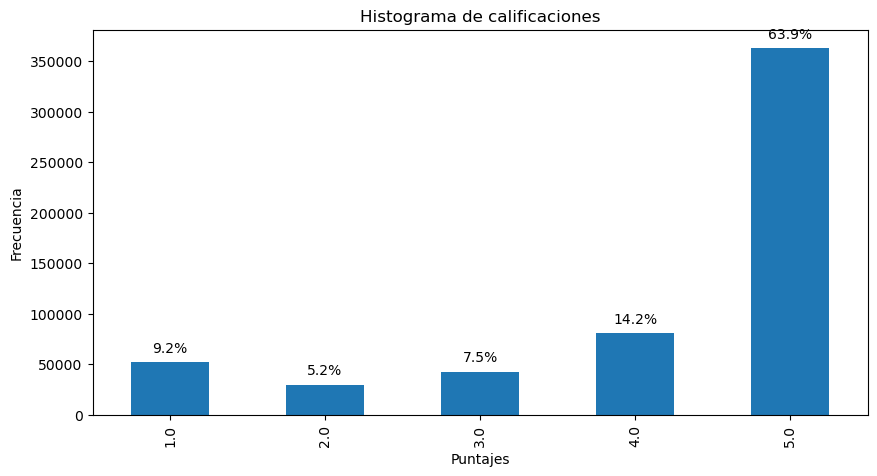

In [8]:
# Crear el histograma de 'review/score'
ax = df['review/score'].value_counts().sort_index().plot(
    kind='bar',
    title='Histograma de calificaciones',
    figsize=(10, 5)
)

# Establecer las etiquetas de los ejes
ax.set_xlabel('Puntajes')
ax.set_ylabel('Frecuencia')

# Calcular el porcentaje y añadirlo sobre cada barra
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [9]:
#Busca nulos
print(df.isnull().sum())

product/productId     0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64


In [46]:
# Dividir la columna 'review/helpfulness' en dos nuevas columnas 'helpfulness_numerator' y 'helpfulness_denominator'
df[['helpfulness_numerator', 'helpfulness_denominator']] = df['review/helpfulness'].str.split('/', expand=True)

# Convertir las nuevas columnas a tipo numérico
df['helpfulness_numerator'] = pd.to_numeric(df['helpfulness_numerator'])
df['helpfulness_denominator'] = pd.to_numeric(df['helpfulness_denominator'])

# Mostrar el DataFrame modificado
print(df)

       product/productId   review/userId               review/profileName  \
0             B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1             B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2             B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3             B000UA0QIQ  A395BORC6FGVXV                             Karl   
4             B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...                  ...             ...                              ...   
568449        B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450        B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451        B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452        B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453        B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

       review/helpfulness review/score review/time  \
0                    

In [92]:
# Crear una nueva columna 'helpfulness_ratio' manejando el caso en que tanto el numerador como el denominador son cero
df['helpfulness_score'] = df.apply(
    lambda row: "Sin info" if row['helpfulness_denominator'] == 0 and row['helpfulness_numerator'] == 0 else
    (row['helpfulness_numerator'] / row['helpfulness_denominator'] * 5) if row['helpfulness_denominator'] != 0 else 0,
    axis=1
)

In [93]:
df

,product/productId,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,helpfulness_numerator,helpfulness_denominator,helpfulness_score,helpfulness_score_rounded,review_combined
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1/1,5.0,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,1,5.0,5.0,Good Quality Dog Food I have bought several of...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0/0,1.0,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0,Sin info,0.0,Not as Advertised Product arrived labeled as J...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1/1,4.0,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1,1,5.0,5.0,"""Delight"" says it all This is a confection tha..."
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3/3,2.0,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,3,3,5.0,5.0,Cough Medicine If you are looking for the secr...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0/0,5.0,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,0,0,Sin info,0.0,Great taffy Great taffy at a great price. The...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0/0,5.0,2011-03-09,Will not do without,Great for sesame chicken..this is a good if no...,0,0,Sin info,0.0,Will not do without Great for sesame chicken.....
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0/0,2.0,2012-03-09,disappointed,I'm disappointed with the flavor. The chocolat...,0,0,Sin info,0.0,disappointed I'm disappointed with the flavor....
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2/2,5.0,2012-02-21,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2,2,5.0,5.0,Perfect for our maltipoo These stars are small...
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1/1,5.0,2012-03-13,Favorite Training and reward treat,These are the BEST treats for training and rew...,1,1,5.0,5.0,Favorite Training and reward treat These are t...


In [96]:
# Aproximar los valores de helpfulness_score al múltiplo de 0.5 más cercano
df['helpfulness_score_rounded'] = df.apply(
    lambda row: ("Sin info" if row['helpfulness_score'] == "Sin info" else np.round(row['helpfulness_score'] * 2) / 2),
    axis=1
)


In [99]:
# Eliminar las filas con helpfulness_score mayor a 5, conservando las filas con "Sin info"
df = df[(df['helpfulness_score'] == "Sin info") | (pd.to_numeric(df['helpfulness_score'], errors='coerce') <= 5)]



C:\Users\natal\AppData\Local\Temp\ipykernel_33752\52138589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['helpfulness_score_rounded'] = pd.to_numeric(df_numeric['helpfulness_score_rounded'])


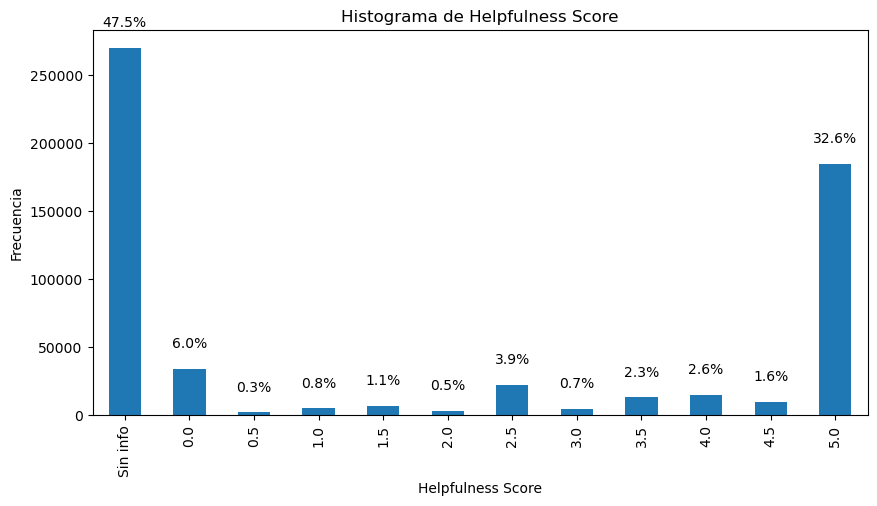

In [102]:
# Eliminar las filas con 'Sin info'
df_numeric = df[df['helpfulness_score_rounded'] != 'Sin info']

# Convertir 'helpfulness_score_rounded' a tipo numérico
df_numeric['helpfulness_score_rounded'] = pd.to_numeric(df_numeric['helpfulness_score_rounded'])

# Obtener los valores únicos y sus conteos
value_counts_numeric = df_numeric['helpfulness_score_rounded'].value_counts().sort_index()

# Calcular la cuenta de 'Sin info'
count_sin_info = (df['helpfulness_score_rounded'] == 'Sin info').sum()

# Crear una Serie para 'Sin info'
value_counts_sin_info = pd.Series([count_sin_info], index=['Sin info'])

# Concatenar las Series
value_counts = pd.concat([value_counts_sin_info, value_counts_numeric])

# Crear el histograma
ax = value_counts.plot(kind='bar', title='Histograma de Helpfulness Score', figsize=(10, 5))
ax.set_xlabel('Helpfulness Score')
ax.set_ylabel('Frecuencia')

# Agregar los porcentajes encima de las barras
for i, v in enumerate(value_counts):
    if isinstance(v, int):  # Evitar agregar porcentajes sobre "Sin info"
        ax.text(i, v + 0.05 * max(value_counts), f'{v / sum(value_counts) * 100:.1f}%', ha='center', va='bottom')

plt.show()


In [51]:
df['review/score'] = pd.to_numeric(df['review/score'])

In [17]:
len(df)

568452

In [62]:
# Extraer los años de la columna 'fecha'
df['año'] = df['review/time'].dt.year

frecuencia_por_año = df['año'].value_counts()

# Imprimir los años y su frecuencia
print("Año\tFrecuencia")
for año, frecuencia in frecuencia_por_año.items():
    print(f"{año}\t{frecuencia}")

Año	Frecuencia
2012	198659
2011	163299
2010	85884
2009	55326
2008	34161
2007	22300
2006	6671
2005	1335
2004	561
2003	132
2002	73
2000	32
2001	13
1999	6


C:\Users\natal\AppData\Local\Temp\ipykernel_30236\4134295696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['año'] = df['review/time'].dt.year


In [66]:
# Contar la frecuencia de cada mes
frecuencia_por_mes = df['review/time'].dt.month.value_counts()

# Imprimir los meses y su frecuencia
print("Mes\tFrecuencia")
for mes, frecuencia in frecuencia_por_mes.items():
    print(f"{mes}\t{frecuencia}")

Mes	Frecuencia
10	55761
9	55740
8	50526
1	50367
7	48419
3	48367
5	46226
2	45356
6	44478
4	44473
12	41753
11	36986


In [67]:
#Distribución días de la semana
frecuencia_por_dia_semana = df['review/time'].dt.dayofweek.value_counts()

print("Día de la semana\tFrecuencia")
for dia_semana, frecuencia in frecuencia_por_dia_semana.items():
    print(f"{dia_semana}\t\t\t{frecuencia}")

Día de la semana	Frecuencia
3			87078
2			85994
1			85857
0			85363
4			79682
6			72790
5			71688


In [87]:
# Obtener el número de valores únicos de 'product/productId'
num_product_ids_unicos = df['product/productId'].nunique()

# Obtener el número de valores únicos de 'review/userId'
num_user_ids_unicos = df['review/userId'].nunique()

# Obtener el número de valores únicos de 'review/profileName'
num_profile_names_unicos = df['review/profileName'].nunique()

print("Número de Product IDs únicos:", num_product_ids_unicos)
print("Número de User IDs únicos:", num_user_ids_unicos)
print("Número de Profile Names únicos:", num_profile_names_unicos)

Número de Product IDs únicos: 74258
Número de User IDs únicos: 256059
Número de Profile Names únicos: 218418


## Procesamieto del texto

In [52]:
# Concatenar 'review/summary' y 'review/text' en una nueva columna
df['review_combined'] = df['review/summary'] + " " + df['review/text']

#Base de datos final a usar 
df_final = df[['product/productId', 'review/userId', 'review/profileName', 'review/score', 'helpfulness_score_rounded','review_combined']]


In [53]:
df_final

,product/productId,review/userId,review/profileName,review/score,helpfulness_score_rounded,review_combined
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5.0,5.0,Good Quality Dog Food I have bought several of...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1.0,0.0,Not as Advertised Product arrived labeled as J...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4.0,5.0,"""Delight"" says it all This is a confection tha..."
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2.0,5.0,Cough Medicine If you are looking for the secr...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5.0,0.0,Great taffy Great taffy at a great price. The...
...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,5.0,0.0,Will not do without Great for sesame chicken.....
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2.0,0.0,disappointed I'm disappointed with the flavor....
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",5.0,5.0,Perfect for our maltipoo These stars are small...
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",5.0,5.0,Favorite Training and reward treat These are t...


In [54]:
# Función para limpiar texto
def limpiar(texto):
    texto = texto.lower()
    texto = re.sub(r'[^A-Za-z0-9\s]', '', texto)  
    texto = re.sub(r'\s+', ' ', texto)  
    return texto.strip()

In [55]:
df_final['review_combined'] = df_final['review_combined'].apply(limpiar)

C:\Users\natal\AppData\Local\Temp\ipykernel_33752\251034048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['review_combined'] = df_final['review_combined'].apply(limpiar)


In [88]:
df_final

,product/productId,review/userId,review/profileName,review/score,helpfulness_score_rounded,review_combined
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5.0,5.0,good quality dog food i have bought several of...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1.0,0.0,not as advertised product arrived labeled as j...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4.0,5.0,delight says it all this is a confection that ...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2.0,5.0,cough medicine if you are looking for the secr...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5.0,0.0,great taffy great taffy at a great price there...
...,...,...,...,...,...,...
568449,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,5.0,0.0,will not do without great for sesame chickenth...
568450,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2.0,0.0,disappointed im disappointed with the flavor t...
568451,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",5.0,5.0,perfect for our maltipoo these stars are small...
568452,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",5.0,5.0,favorite training and reward treat these are t...


In [20]:
!pip install vaderSentiment

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Inicializar el analizador de sentimientos
analyzer = SentimentIntensityAnalyzer()

# Analizar el sentimiento de cada reseña combinada
df['sentiment'] = df['review_combined'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Clasificar los sentimientos como positivos, negativos o neutros
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

# Mostrar el DataFrame con los sentimientos
print(df[['review_combined', 'sentiment', 'sentiment_label']])

C:\Users\natal\AppData\Local\Temp\ipykernel_33752\3534076854.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['review_combined'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
C:\Users\natal\AppData\Local\Temp\ipykernel_33752\3534076854.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))


                                          review_combined  sentiment  \
0       Good Quality Dog Food I have bought several of...     0.9583   
1       Not as Advertised Product arrived labeled as J...    -0.5664   
2       Delight says it all This is a confection that ...     0.9066   
3       Cough Medicine If you are looking for the secr...     0.4404   
4       Great taffy Great taffy at a great price There...     0.9661   
...                                                   ...        ...   
568449  Will not do without Great for sesame chickenth...     0.7959   
568450  disappointed Im disappointed with the flavor T...    -0.9419   
568451  Perfect for our maltipoo These stars are small...     0.7630   
568452  Favorite Training and reward treat These are t...     0.9849   
568453  Great Honey I am very satisfied product is as ...     0.8016   

       sentiment_label  
0             positive  
1             negative  
2             positive  
3             positive  
4         

In [108]:
# Tomar una muestra aleatoria de 30,000 registros
df_sample = df_final.sample(n=30000, random_state=42)

In [109]:
# Crear un mapeo de usuarios y productos a IDs únicos
user_ids = df_sample['review/userId'].unique()
product_ids = df_sample['product/productId'].unique()

user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
product_id_map = {pid: idx + len(user_ids) for idx, pid in enumerate(product_ids)}
node_mapping = {**user_id_map, **product_id_map}

In [122]:
# Crear grafo
G = nx.DiGraph()

# Añadir nodos y aristas
for _, row in df_sample.iterrows():
    G.add_node(node_mapping[row['review/userId']], type='user')
    G.add_node(node_mapping[row['product/productId']], type='product')
    G.add_edge(node_mapping[row['review/userId']], node_mapping[row['product/productId']],weight=row['review/score'])

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

num_nodes = len(node_mapping)
num_node_features = 745 
x = torch.randn((num_nodes, num_node_features), dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data = train_test_split_edges(data)

### Modelos - GCN

In [138]:
##
class ImprovedGraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ImprovedGraphAutoencoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def encode(self, data):
        x = self.conv1(data.x, data.train_pos_edge_index)
        x = x.relu()
        x = self.conv2(x, data.train_pos_edge_index)
        x = x.relu()
        return self.conv3(x, data.train_pos_edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedGraphAutoencoder(in_channels=num_node_features, hidden_channels=128, out_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#,weight_decay=5e-4)

In [130]:
def get_link_labels(pos_edge_index, neg_edge_index):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train(data):
    model.train()
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=data.train_pos_edge_index.size(1))
    optimizer.zero_grad()
    z = model.encode(data)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test(data):
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=pos_edge_index.size(1))
        z = model.encode(data)
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        pred_labels = (link_probs > 0.5).float()
        accuracy = (pred_labels == link_labels).sum().item() / link_labels.size(0)
        perfs.append(accuracy)
    return perfs

best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train(data)
    val_perf, tmp_test_perf = test(data)
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Val: {best_val_perf:.4f}, Test: {test_perf:.4f}')

Epoch: 010, Loss: 0.6286, Val: 0.5100, Test: 0.4933
Epoch: 020, Loss: 0.5569, Val: 0.5333, Test: 0.5200
Epoch: 030, Loss: 0.4711, Val: 0.5867, Test: 0.5683
Epoch: 040, Loss: 0.4278, Val: 0.6600, Test: 0.6267
Epoch: 050, Loss: 0.4097, Val: 0.6933, Test: 0.6733
Epoch: 060, Loss: 0.4060, Val: 0.7300, Test: 0.6700
Epoch: 070, Loss: 0.4073, Val: 0.7300, Test: 0.6700
Epoch: 080, Loss: 0.4034, Val: 0.7467, Test: 0.6633
Epoch: 090, Loss: 0.4009, Val: 0.7467, Test: 0.6633
Epoch: 100, Loss: 0.4071, Val: 0.7467, Test: 0.6633


In [139]:
def get_link_labels(pos_edge_index, neg_edge_index, device):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train(data):
    model.train()
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, 
                                       num_nodes=data.num_nodes, 
                                       num_neg_samples=data.train_pos_edge_index.size(1))
    optimizer.zero_grad()
    z = model.encode(data)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index, device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = negative_sampling(edge_index=pos_edge_index, 
                                           num_nodes=data.num_nodes, 
                                           num_neg_samples=pos_edge_index.size(1))
        z = model.encode(data)
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index, device)
        pred_labels = (link_probs > 0.5).float()
        accuracy = (pred_labels == link_labels).sum().item() / link_labels.size(0)
        perfs.append(accuracy)
    return perfs

best_val_perf = test_perf = 0
for epoch in range(1, 1001):
    train_loss = train(data)
    val_perf, tmp_test_perf = test(data)
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Val: {best_val_perf:.4f}, Test: {test_perf:.4f}')


Epoch: 010, Loss: 0.6303, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 0.5800, Val: 0.5267, Test: 0.5367
Epoch: 030, Loss: 0.5037, Val: 0.6100, Test: 0.5800
Epoch: 040, Loss: 0.4502, Val: 0.6500, Test: 0.6367
Epoch: 050, Loss: 0.4230, Val: 0.6900, Test: 0.6583
Epoch: 060, Loss: 0.4085, Val: 0.6900, Test: 0.6583
Epoch: 070, Loss: 0.4061, Val: 0.7000, Test: 0.6283
Epoch: 080, Loss: 0.4088, Val: 0.7000, Test: 0.6283
Epoch: 090, Loss: 0.3955, Val: 0.7033, Test: 0.6417
Epoch: 100, Loss: 0.3957, Val: 0.7033, Test: 0.6417
Epoch: 110, Loss: 0.4005, Val: 0.7033, Test: 0.6417
Epoch: 120, Loss: 0.3975, Val: 0.7133, Test: 0.6933
Epoch: 130, Loss: 0.3849, Val: 0.7133, Test: 0.6933
Epoch: 140, Loss: 0.3900, Val: 0.7233, Test: 0.6750
Epoch: 150, Loss: 0.3823, Val: 0.7233, Test: 0.6750
Epoch: 160, Loss: 0.3843, Val: 0.7233, Test: 0.6750
Epoch: 170, Loss: 0.3886, Val: 0.7267, Test: 0.6800
Epoch: 180, Loss: 0.3835, Val: 0.7400, Test: 0.7183
Epoch: 190, Loss: 0.3911, Val: 0.7400, Test: 0.7183
Epoch: 200, 

In [140]:
z = model.encode(data)
predict_edge_index = model.decode_all(z)
predict_edge_index = pd.DataFrame(predict_edge_index.cpu().numpy().T, columns=['start_node', 'end_node'])
print(predict_edge_index.head())

   start_node  end_node
0           0         0
1           0         2
2           0         3
3           0         4
4           0         5


### GCN - LeakyReLu

In [148]:
class ImprovedGraphAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ImprovedGraphAutoencoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def encode(self, data):
        x = self.conv1(data.x, data.train_pos_edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv2(x, data.train_pos_edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return self.conv3(x, data.train_pos_edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

# Asignar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedGraphAutoencoder(in_channels=num_node_features, hidden_channels=128, out_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Definir las funciones de entrenamiento y prueba

def get_link_labels(pos_edge_index, neg_edge_index, device):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train(data):
    model.train()
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, 
        num_nodes=data.num_nodes, 
        num_neg_samples=data.train_pos_edge_index.size(1)
    )
    optimizer.zero_grad()
    z = model.encode(data)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index, device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index, 
            num_nodes=data.num_nodes, 
            num_neg_samples=pos_edge_index.size(1)
        )
        z = model.encode(data)
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index, device)
        pred_labels = (link_probs > 0.5).float()
        accuracy = (pred_labels == link_labels).sum().item() / link_labels.size(0)
        perfs.append((accuracy))
    return perfs

# Añadir un early stopping para evitar el sobreentrenamiento
best_val_perf = test_perf = 0
patience = 500
patience_counter = 0

for epoch in range(1, 1001):
    train_loss = train(data)
    val_perf, tmp_test_perf = test(data)
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Val: {best_val_perf:.4f}, Test: {test_perf:.4f}')
    
    if patience_counter >= patience:
        print("Early stopping...")
        break


Epoch: 010, Loss: 1.8241, Val: 0.5533, Test: 0.5017
Epoch: 020, Loss: 1.1003, Val: 0.5633, Test: 0.4833
Epoch: 030, Loss: 0.8813, Val: 0.5667, Test: 0.4883
Epoch: 040, Loss: 0.7252, Val: 0.5667, Test: 0.4883
Epoch: 050, Loss: 0.6383, Val: 0.5667, Test: 0.4883
Epoch: 060, Loss: 0.5746, Val: 0.5667, Test: 0.4883
Epoch: 070, Loss: 0.5449, Val: 0.5667, Test: 0.4883
Epoch: 080, Loss: 0.5106, Val: 0.5667, Test: 0.4883
Epoch: 090, Loss: 0.4745, Val: 0.5667, Test: 0.4883
Epoch: 100, Loss: 0.4453, Val: 0.5667, Test: 0.4883
Epoch: 110, Loss: 0.4321, Val: 0.5667, Test: 0.4883
Epoch: 120, Loss: 0.4267, Val: 0.5667, Test: 0.4883
Epoch: 130, Loss: 0.4099, Val: 0.5667, Test: 0.4883
Epoch: 140, Loss: 0.4143, Val: 0.5667, Test: 0.4883
Epoch: 150, Loss: 0.4049, Val: 0.5667, Test: 0.4883
Epoch: 160, Loss: 0.4021, Val: 0.5667, Test: 0.4883
Epoch: 170, Loss: 0.3975, Val: 0.5700, Test: 0.5000
Epoch: 180, Loss: 0.3987, Val: 0.5700, Test: 0.5000
Epoch: 190, Loss: 0.3999, Val: 0.5700, Test: 0.5000
Epoch: 200, 

### VGAE

In [152]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges, negative_sampling
from sklearn.metrics import precision_score, recall_score, f1_score

# Definir el encoder
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

# Definir el VGAE usando el encoder
class VariationalGraphAutoencoder(VGAE):
    def __init__(self, encoder):
        super(VariationalGraphAutoencoder, self).__init__(encoder)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

# Configuración del dispositivo y los datos
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(in_channels=num_node_features, hidden_channels=128, out_channels=64)
model = VariationalGraphAutoencoder(encoder).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def get_link_labels(pos_edge_index, neg_edge_index, device):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train(data):
    model.train()
    optimizer.zero_grad()
    neg_edge_index = negative_sampling(edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=data.train_pos_edge_index.size(1))
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index, device)
    loss = model.recon_loss(z, data.train_pos_edge_index, neg_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=pos_edge_index.size(1))
        z = model.encode(data.x, data.train_pos_edge_index)
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index, device)
        pred_labels = (link_probs > 0.5).float()
        accuracy = (pred_labels == link_labels).sum().item() / link_labels.size(0)
        precision = precision_score(link_labels.cpu(), pred_labels.cpu())
        recall = recall_score(link_labels.cpu(), pred_labels.cpu())
        f1 = f1_score(link_labels.cpu(), pred_labels.cpu())
        perfs.append((accuracy, precision, recall, f1))
    return perfs

best_val_perf = 0
test_perf = (0, 0, 0, 0)
patience = 50
patience_counter = 0

for epoch in range(1, 101):
    train_loss = train(data)
    val_perf, tmp_test_perf = test(data)
    val_accuracy, val_precision, val_recall, val_f1 = val_perf
    if val_accuracy > best_val_perf:
        best_val_perf = val_accuracy
        test_perf = tmp_test_perf
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Val Acc: {val_accuracy:.4f}, Test Acc: {test_perf[0]:.4f}, Test Precision: {test_perf[1]:.4f}, Test Recall: {test_perf[2]:.4f}, Test F1: {test_perf[3]:.4f}')
    
    if patience_counter >= patience:
        print("Early stopping...")
        break


Epoch: 010, Loss: 3.1072, Val Acc: 0.5100, Test Acc: 0.4950, Test Precision: 0.4956, Test Recall: 0.5667, Test F1: 0.5288
Epoch: 020, Loss: 1.9284, Val Acc: 0.5500, Test Acc: 0.4750, Test Precision: 0.4762, Test Recall: 0.5000, Test F1: 0.4878
Epoch: 030, Loss: 1.3173, Val Acc: 0.5067, Test Acc: 0.4750, Test Precision: 0.4762, Test Recall: 0.5000, Test F1: 0.4878
Epoch: 040, Loss: 1.0277, Val Acc: 0.5067, Test Acc: 0.4750, Test Precision: 0.4762, Test Recall: 0.5000, Test F1: 0.4878
Epoch: 050, Loss: 0.9430, Val Acc: 0.5500, Test Acc: 0.4750, Test Precision: 0.4762, Test Recall: 0.5000, Test F1: 0.4878
Epoch: 060, Loss: 0.8759, Val Acc: 0.5000, Test Acc: 0.4750, Test Precision: 0.4762, Test Recall: 0.5000, Test F1: 0.4878
Epoch: 070, Loss: 0.8426, Val Acc: 0.4867, Test Acc: 0.5000, Test Precision: 0.5000, Test Recall: 0.5200, Test F1: 0.5098
Epoch: 080, Loss: 0.8295, Val Acc: 0.4733, Test Acc: 0.5000, Test Precision: 0.5000, Test Recall: 0.5200, Test F1: 0.5098
Epoch: 090, Loss: 0.8245